## Marie 2020

Tests

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
# import functions as f
# import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        False,
}

PTHS = {
    'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
}

### 1) SAR data

In [3]:
### OPEN DATA
dsg = xr.open_dataset(PTHS['ds_glob_path'])
dsg.where(dsg.storm_name == 'MARIE', drop=True).B_hol

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'B_hol' (time: 5)>
array([1.79940384, 2.37396689, 1.67238905, 1.78461914, 1.59906357])
Coordinates:
  * time     (time) datetime64[ns] 2020-10-02T02:23:31 ... 2020-10-04T14:29:05

In [4]:
### MARIE
p1    = 'rs2--owi-ca-20201001t133839-20201001t133955-00003-3268A_sw_ep182020_cyclone.nc'
p2    = 'rs2--owi-ca-20201002t022254-20201002t022409-00003-3268A_sw_ep182020_cyclone.nc'
p3    = 's1a-ew-owi-ca-20201003t022600-20201003t022817-000003-04082E_sw_ep182020_cyclone.nc'
p4    = 'rs2--owi-ca-20201003t141913-20201003t142136-00003-3268A_sw_ep182020_cyclone.nc'
p5    = 's1b-ew-owi-ca-20201004t142803-20201004t143007-000003-02CF68_sw_ep182020_cyclone.nc'

p1dsg = 'rs2--owi-cm-20201001t133839-20201001t133955-00003-3268A_sw.nc'
p2dsg = 'rs2--owi-cm-20201002t022254-20201002t022409-00003-3268A_sw.nc'
p3dsg = 's1a-ew-owi-cm-20201003t022600-20201003t022817-000003-04082E_sw.nc'
p4dsg = 'rs2--owi-cm-20201003t141913-20201003t142136-00003-3268A_sw.nc'
p5dsg = 's1b-ew-owi-cm-20201004t142803-20201004t143007-000003-02CF68_sw.nc'

Text(0.5, 1.0, 'MARIE, EP182020')

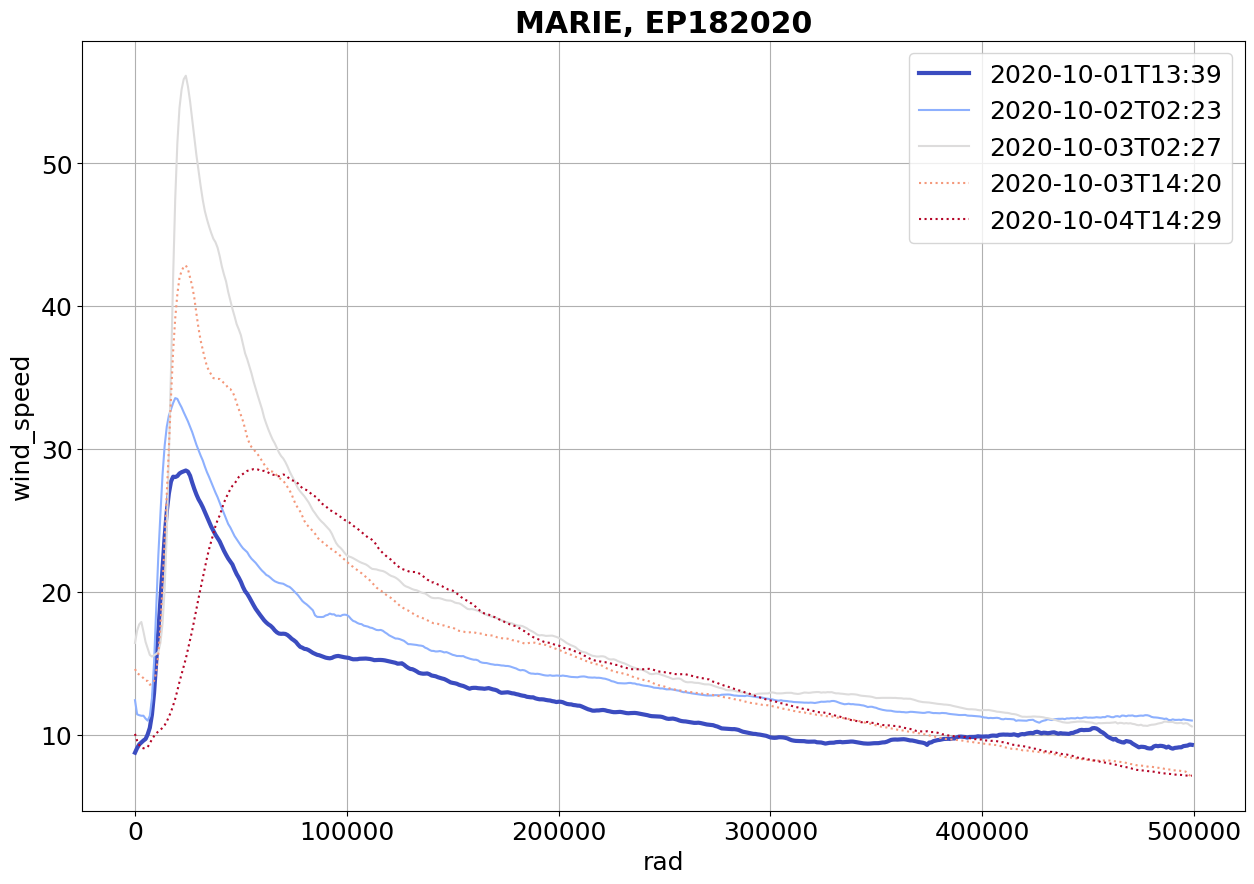

In [5]:
colors = mpl.cm.coolwarm(np.linspace(0, 1, 5))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
plt.grid();plt.legend();plt.title('MARIE, EP182020', weight='bold')

# 36hrs between both images

### 2) Functions and model

In [6]:
### FUNCTIONS

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    # B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

rs = np.linspace(10, 500000, 50001) # define dr accordingly

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 10 # meters
    return (1 / r) * np.gradient(r * v, dr)

# def get_scales(ds, H=10000, show=True, L=100000, delta_t=24):
#     lat    = float(ds.lat.isel(rad=0).mean(dim='theta', skipna=True))
#     fcor   = abs(coriolis(lat)) # maybe divide by 10 to get reasonable value of fcor * L

#     # To define U_star
#     ws     = ds.wind_speed.mean(dim='theta', skipna=True)
#     Rmax   = float(ws.rad[int(ws.argmax())]) # m
#     Vmax   = float(ws.max())                  # m/s
#     U_star = fcor * Rmax # m/s

#     if show:
#         print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
#         print('radial velocity     --> {:.2f} m/s'.format(U_star))
#         print('tangential velocity --> {:.2f} m/s'.format(fcor * L))
#         print('vertical velocity   --> {:.2f} m/s'.format(H * U_star / L))
#         print('characteristic tangential velocity --> {:.1f} m/s'.format(fcor * L)) 
#         print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))
    
#     return Vmax, Rmax, fcor

def get_v(ds, fcor, L):
    ws = ds.wind_speed.mean(dim='theta', skipna=True)
    r = ws.rad / L
    v = ws     / (fcor * L)

    V = xr.DataArray(
        data=v,
        coords={'rad': r}
    )
    return V

def v_k10(v0, t, lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                  # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)}) # Inner-core: v0 interpolated on r * e^t
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))  # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})            # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)           # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})            # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(t) + v0.rad * (np.exp(2 * t) - 1) / 2                                      # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * v0.rad) + np.log(v0.rad) / v0.rad + t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + t / v0.rad                                                     # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)      # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

### 3) Characteristic radius R+

In [21]:
n   = PRMS['n']
DSs = dsg.mean(dim='theta', skipna=True)

# Initialize
DSs['R_plus'] = DSs['Vmax_1D'].copy(deep=True) * np.nan
DSs['V_plus'] = DSs['Vmax_1D'].copy(deep=True) * np.nan

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for t in tqdm(np.arange(len(DSs.time))):
        ds       = DSs.isel(time=t)
        Vh       = holland_profile(rs, float(abs(ds.lat_center)), float(ds.pn_hol), float(ds.pc_hol), float(ds.Vmin_hol), float(ds.Rmax_hol), float(ds.Vmax_hol))
        rm       = float(ds.Rmax_hol)
        out      = rs > rm                             # To find outer-core
        r        = rs[out]
        vrt      = vorticity(rs, Vh)[out]              # Relative vorticity
        vrt_plan = float(abs(coriolis(ds.lat_center))) # Planetary vorticity

        try: 
            R_plus =  r[abs(vrt - n * vrt_plan) < 1e-7][0] 
            V_plus = ds.sel(rad=slice(R_plus - 500, None)).wind_speed[0]
        except IndexError:
            R_plus = V_plus = np.nan

        DSs['R_plus'][t] = R_plus
        DSs['V_plus'][t] = V_plus

  0%|          | 0/335 [00:00<?, ?it/s]

In [22]:
# Open profiles
D  = {}
Vh = {}
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg]):
    D[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    Vh[str(k)] = holland_profile(rs, float(abs(D[str(k)].lat_center)), float(D[str(k)].pn_hol), float(D[str(k)].pc_hol), float(D[str(k)].Vmin_hol), float(D[str(k)].Rmax_hol), float(D[str(k)].Vmax_hol))

R+  = 58 km
Tau = 7.5 hr


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


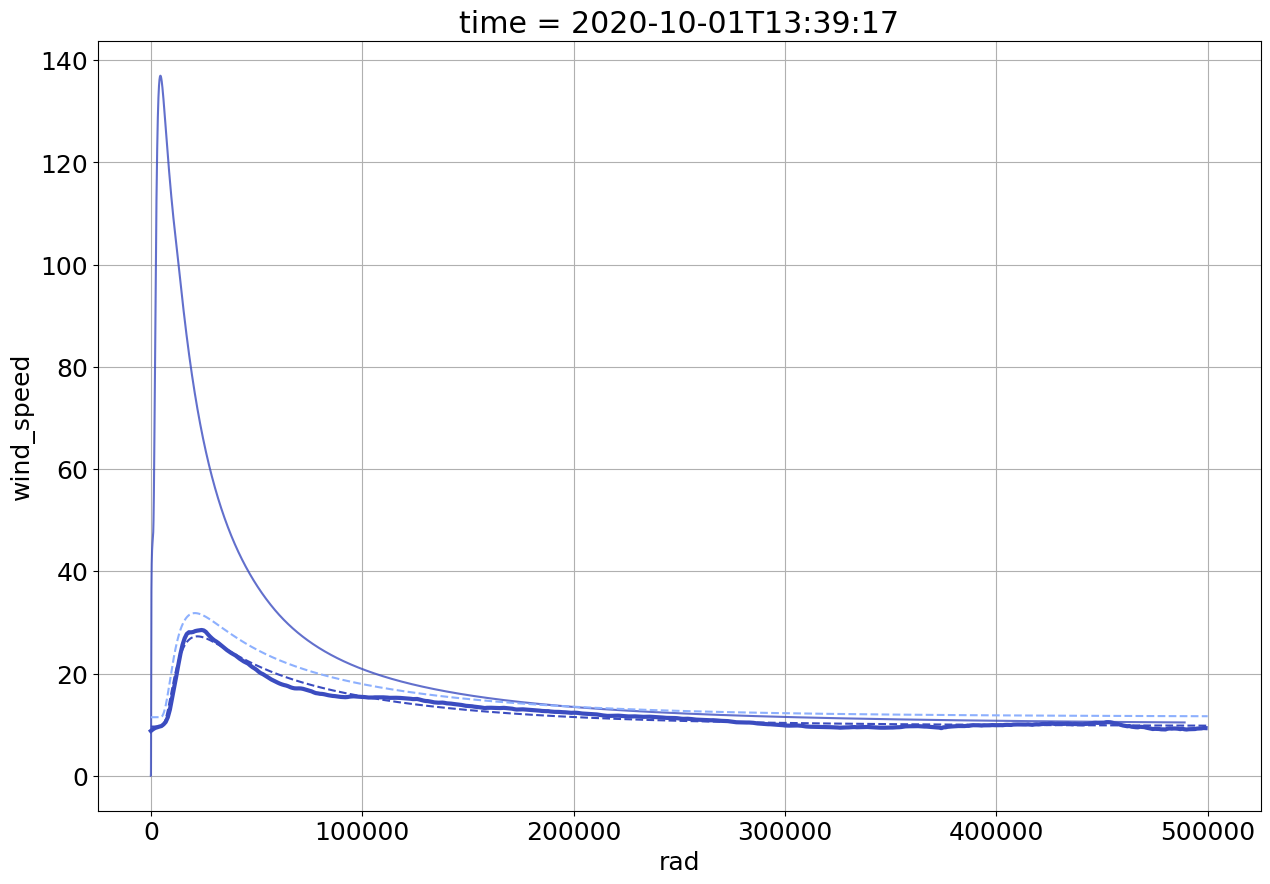

In [23]:
# Get Holland profiles
D1  = DSs.where(DSs.sat_file == p1dsg, drop=True).isel(time=0)
Vh1 = holland_profile(rs, float(abs(D1.lat_center)), float(D1.pn_hol), float(D1.pc_hol), float(D1.Vmin_hol), float(D1.Rmax_hol), float(D1.Vmax_hol))

# Characteristic scales
L1   = float(D1.R_plus)
f1   = float(abs(coriolis(D1.lat_center)))
# tau1 = float(D1.R_plus / D1.V_plus)
# tau1 = float(D1.R_plus / D1.Vmax_1D)
# tau1 = float((D1.Vmax_1D ** 2) / (2 * 10 * 1e-3 * f1 * L1))
tau1 = float(1 / f1)
print('R+  = {:.0f} km'.format(L1 / 1000))
print('Tau = {:.1f} hr'.format(tau1 / 3600))

# Delta time before next image
dt   = 12 # hr

# Get V in Xarray
V1 = xr.DataArray(
    data=Vh1 / (f1 * L1),
    coords={'rad': rs / L1}
)

# Apply KK10
# lbda  = 0.5 # 0.3
# V1_nrm = (V1-np.min(V1))/(np.max(V1)-np.min(V1))
# lbda = V1_nrm - 0.5
lbda = lbda1
v_new = v_k10(V1, t=dt / (tau1 / 3600), lbda=lbda)
v_nof = v_k10(V1, t=dt / (tau1 / 3600), lbda=None) # No friction

# Plot
D1.wind_speed.plot(c=colors[0], linewidth=3)
plt.plot(rs, Vh1,  c=colors[0], linestyle='dashed')
plt.plot(V1.rad * L1, v_new * f1 * L1, label='KK11 at t + 12hr', c=colors[0], alpha=0.8)
# plt.plot(V1.rad * L1, v_nof * f1 * L1, label='KK11 no friction', c='k')
plt.plot(rs, Vh2,  c=colors[1], linestyle='dashed')

# # Plot all profile times
# for k in range(5):
#     plt.plot(rs, Vh[str(k)],  c=colors[k], linestyle='dashed')

plt.grid()

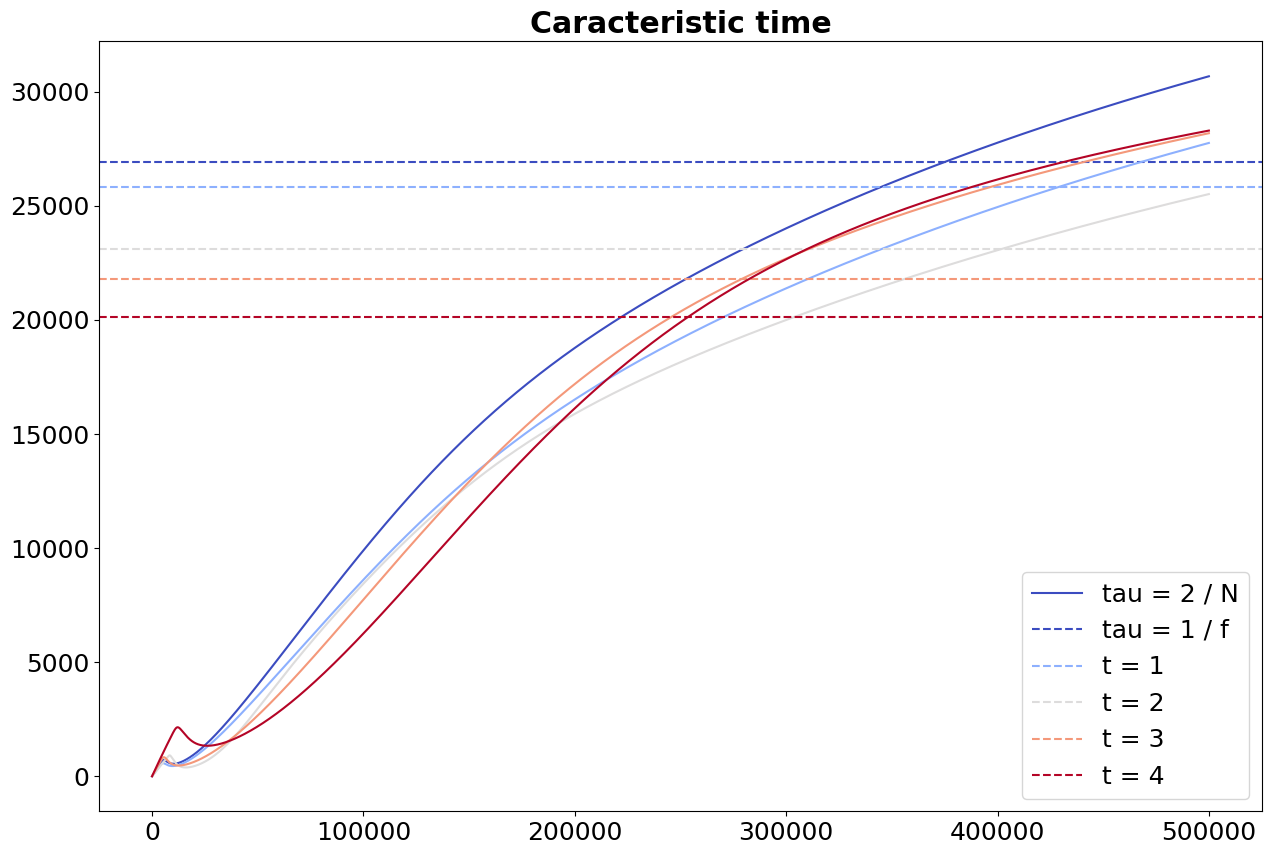

In [24]:
def N(r, M):
    '''Rotational stability frequency'''
    dr = 10 # meters
    N2 = np.gradient(M ** 2, dr) / (r ** 3)
    return np.sqrt(N2)

M1 = rs * Vh1 + 0.5 * f1 * (rs ** 2)
M2 = rs * Vh['1'] + 0.5 * float(abs(coriolis(D['1'].lat_center))) * (rs ** 2)
M3 = rs * Vh['2'] + 0.5 * float(abs(coriolis(D['2'].lat_center))) * (rs ** 2)
M4 = rs * Vh['3'] + 0.5 * float(abs(coriolis(D['3'].lat_center))) * (rs ** 2)
M5 = rs * Vh['4'] + 0.5 * float(abs(coriolis(D['4'].lat_center))) * (rs ** 2)

plt.title('Caracteristic time', weight='bold')
plt.plot(rs, 2 / N(rs, M1), c=colors[0], label='tau = 2 / N')
plt.axhline(tau1,           c=colors[0], linestyle='dashed', label='tau = 1 / f')

plt.plot(rs, 2 / N(rs, M2), c=colors[1])
plt.axhline(1 / float(abs(coriolis(D['1'].lat_center))), c=colors[1], linestyle='dashed', label='t = 1')

plt.plot(rs, 2 / N(rs, M3), c=colors[2])
plt.axhline(1 / float(abs(coriolis(D['2'].lat_center))), c=colors[2], linestyle='dashed', label='t = 2')

plt.plot(rs, 2 / N(rs, M4), c=colors[3])
plt.axhline(1 / float(abs(coriolis(D['3'].lat_center))), c=colors[3], linestyle='dashed', label='t = 3')

plt.plot(rs, 2 / N(rs, M5), c=colors[4])
plt.axhline(1 / float(abs(coriolis(D['4'].lat_center))), c=colors[4], linestyle='dashed', label='t = 4')

# plt.plot(rs, np.sqrt(M1), c='k')

plt.legend()

In [25]:
lbda1 = tau1 / (10 * np.sqrt(2 / N(rs, M1)) * M1)

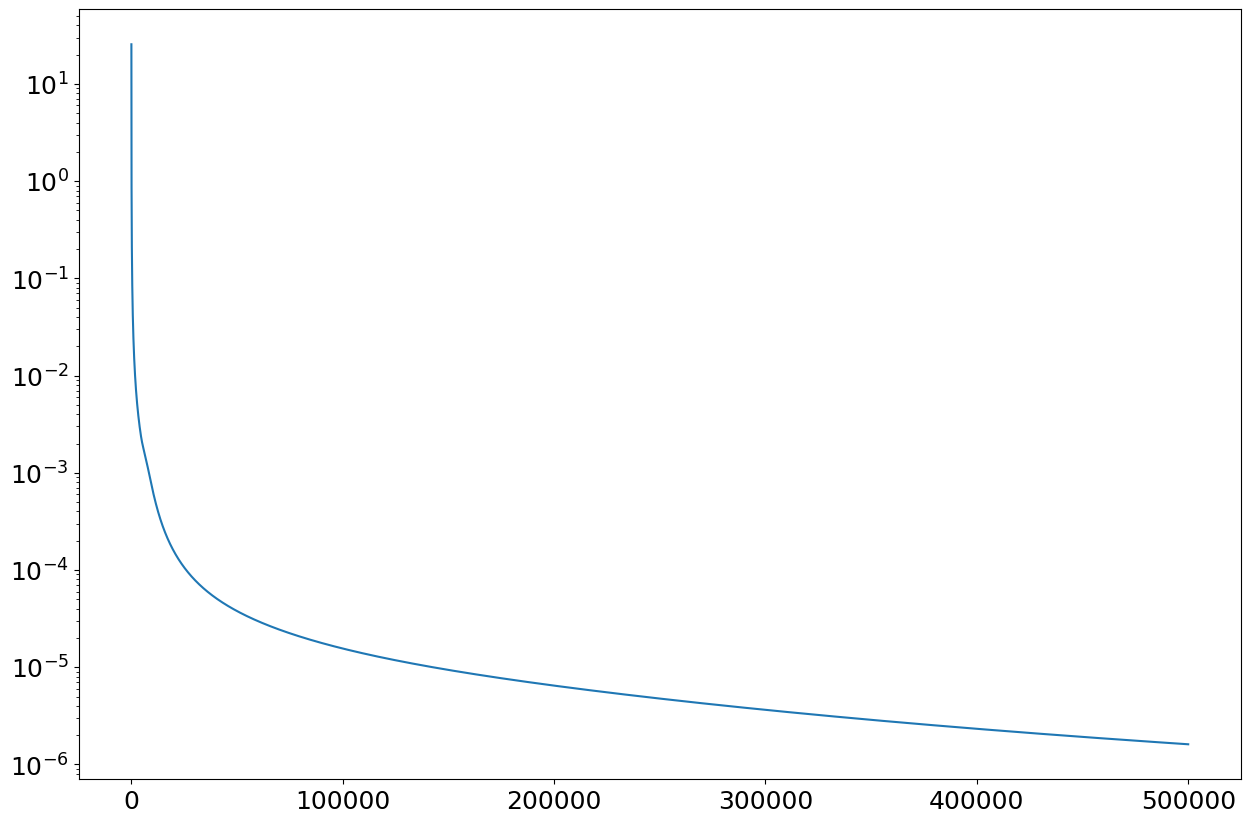

In [26]:
plt.plot(rs, lbda1)
plt.yscale('log')

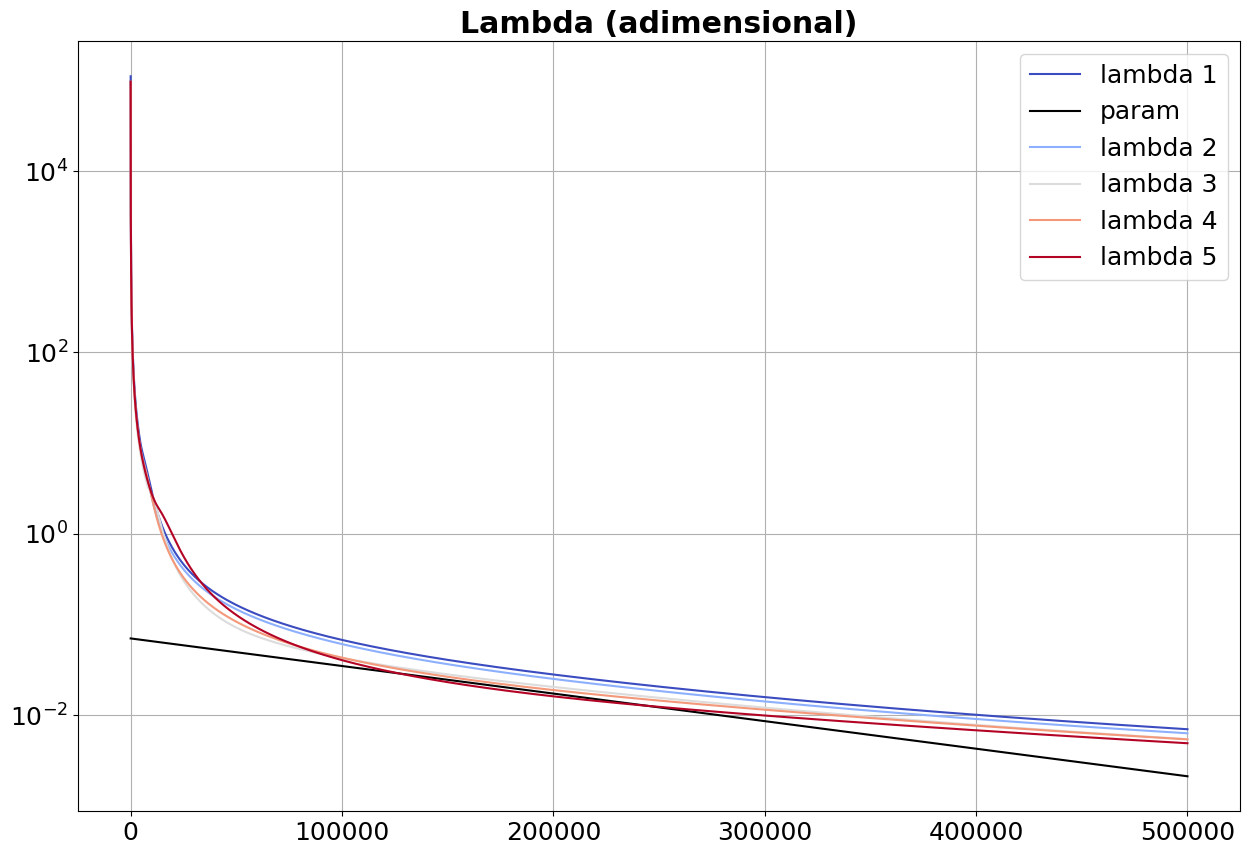

In [27]:
plt.title('Lambda (adimensional)', weight='bold')

# Here 10 stands because K = 100
K       = 10
Cdmax   = 2e-3
factor1 = float(Cdmax * D1.Vmax_1D * D1.Rmax_1D * 1000)
lbda1   = factor1 * tau1 / (np.sqrt(K) * np.sqrt(2 / N(rs, M1)) * M1)

plt.plot(rs, lbda1, c=colors[0], label='lambda 1')

def lbda_param(r, a, b):
    return a * np.exp(-b * r)
plt.plot(rs, lbda_param(rs, 7e-2, 7e-6), c='k', label='param')

plt.plot(rs, factor1 / float(abs(coriolis(D['1'].lat_center))) / (np.sqrt(K) * np.sqrt(2 / N(rs, M2)) * M2), c=colors[1], label='lambda 2')
plt.plot(rs, factor1 / float(abs(coriolis(D['2'].lat_center))) / (np.sqrt(K) * np.sqrt(2 / N(rs, M3)) * M3), c=colors[2], label='lambda 3')
plt.plot(rs, factor1 / float(abs(coriolis(D['3'].lat_center))) / (np.sqrt(K) * np.sqrt(2 / N(rs, M4)) * M4), c=colors[3], label='lambda 4')
plt.plot(rs, factor1 / float(abs(coriolis(D['4'].lat_center))) / (np.sqrt(K) * np.sqrt(2 / N(rs, M5)) * M5), c=colors[4], label='lambda 5')

# plt.ylim(1e-6, 1e-3)
plt.yscale('log')
plt.legend();plt.grid()

R+  = 62 km
Tau = 7.2 hr


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


NameError: name 'Vh3' is not defined

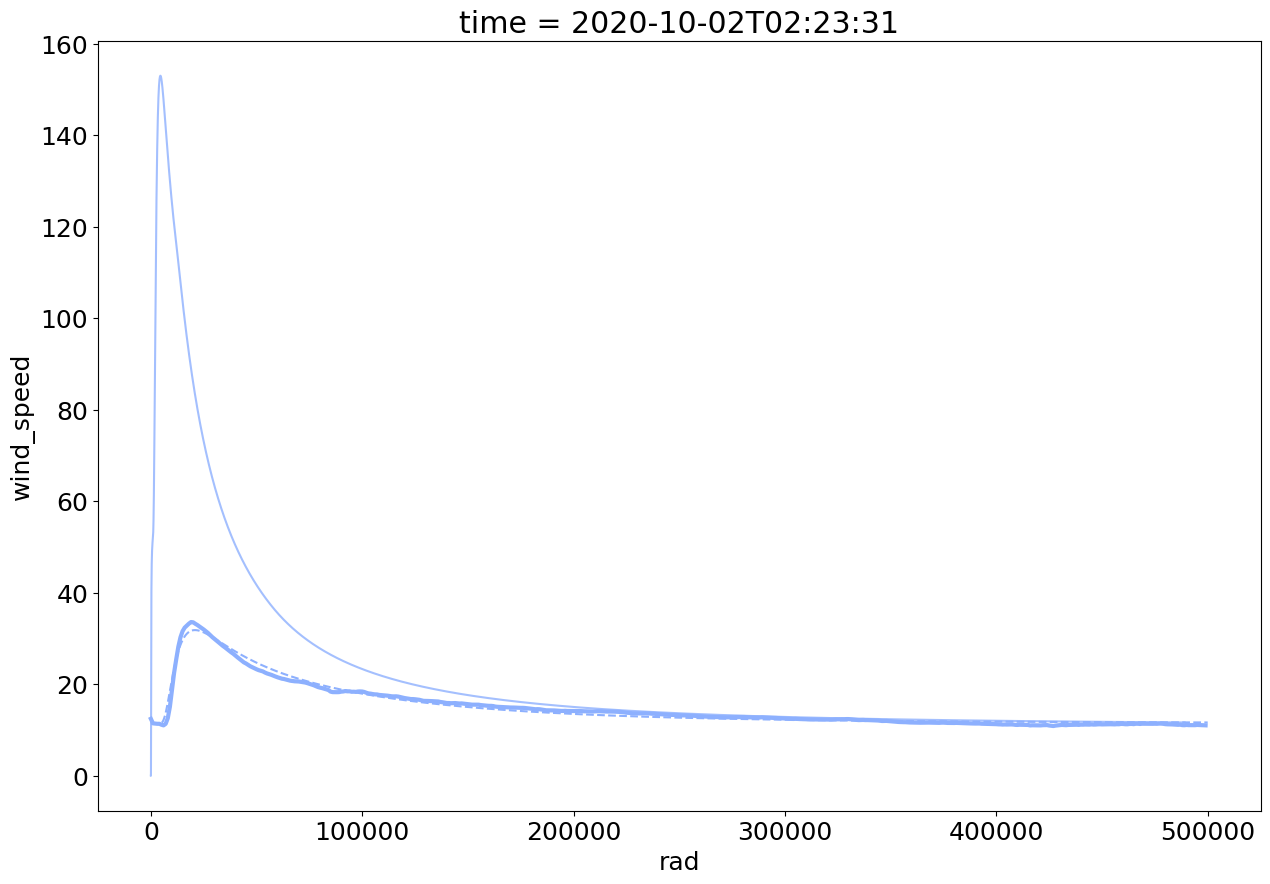

In [28]:
# Second profile
D2  = DSs.where(DSs.sat_file == p2dsg, drop=True).isel(time=0)
Vh2 = holland_profile(rs, float(abs(D2.lat_center)), float(D2.pn_hol), float(D2.pc_hol), float(D2.Vmin_hol), float(D2.Rmax_hol), float(D2.Vmax_hol))

# Characteristic scales
L2   = float(D2.R_plus)
f2   = float(abs(coriolis(D2.lat_center)))
# tau1 = float(D1.R_plus / D1.V_plus)
# tau1 = float(D1.R_plus / D1.Vmax_1D)
# tau1 = float((D1.Vmax_1D ** 2) / (2 * 10 * 1e-3 * f1 * L1))
tau2 = float(1 / f2)
print('R+  = {:.0f} km'.format(L2 / 1000))
print('Tau = {:.1f} hr'.format(tau2 / 3600))

# Delta time before next image
dt   = 1 # hr

# Get V in Xarray
V2 = xr.DataArray(
    data=Vh2 / (f2 * L2),
    coords={'rad': rs / L2}
)

# Apply KK10
lbda = lbda1
Vn2 = v_k10(V2, t=dt / (tau2 / 3600), lbda=lbda1) # V new

# Plot
D2.wind_speed.plot(c=colors[1], linewidth=3)
plt.plot(rs, Vh2,  c=colors[1], linestyle='dashed')
plt.plot(V2.rad * L2, v_new * f2 * L2, label='KK11 at t + 12hr', c=colors[1], alpha=0.8)
plt.plot(rs, Vh3,  c=colors[2], linestyle='dashed')

plt.grid()

### Small iterations

In [15]:
    for t in tqdm(np.arange(len(DSs.time))):
        ds       = DSs.isel(time=t)
        Vh       = holland_profile(rs, float(abs(ds.lat_center)), float(ds.pn_hol), float(ds.pc_hol), float(ds.Vmin_hol), float(ds.Rmax_hol), float(ds.Vmax_hol))
        

        DSs['R_plus'][t] = R_plus
        DSs['V_plus'][t] = V_plus

  0%|          | 0/335 [00:00<?, ?it/s]

In [16]:
type(rs[np.nanargmax(Vn1)])

NameError: name 'Vn1' is not defined

In [ ]:
dt      = 1  # hr  # Time step
n_steps = 20 # hrs # Nb of iterations

# INITIALIZATION
D1  = DSs.where(DSs.sat_file == p1dsg, drop=True).isel(time=0)
Vh1 = holland_profile(rs, float(abs(D1.lat_center)), float(D1.pn_hol), float(D1.pc_hol), float(D1.Vmin_hol), float(D1.Rmax_hol), float(D1.Vmax_hol))
# Characteristic scales
L1   = float(D1.R_plus)
f1   = float(abs(coriolis(D1.lat_center)))
tau1 = float(1 / f1)
# print('R+  = {:.0f} km'.format(L1 / 1000))
# print('Tau = {:.1f} hr'.format(tau1 / 3600))

# Get V in Xarray
V1 = xr.DataArray(
    data=Vh1 / (f1 * L1),
    coords={'rad': rs / L1}
)

# Apply KK10
lbda = lbda1
Vn   = v_k10(V1, t=dt / (tau1 / 3600), lbda=lbda) * f1 * L1 # dimensional

# Plot
D1.wind_speed.plot(c=colors[0], linewidth=3)
plt.plot(rs, Vh1,  c=colors[0], linestyle='dashed')
plt.plot(V1.rad * L1, Vn, c=colors[0], alpha=0.8)
plt.plot(rs, Vh2,  c=colors[1], linestyle='dashed')

# ITERATIONS
# TODO: update lambda
# TODO: update f (coriolis) by linear interpolation, and thus tau1

for t in range(n_steps - 1):
    print(t)
    
    # Compute R+
    rm       = rs[np.nanargmax(Vn)]
    out      = rs > rm                             # To find outer-core
    r        = rs[out]
    vrt      = vorticity(rs, Vn)[out]             # Relative vorticity
    vrt_plan = f1                                  # Planetary vorticity

    try: 
        L =  r[abs(vrt - PRMS['n'] * vrt_plan) < 1e-7][0] # R+
    except IndexError:
        print('Error: R+ non defined.')
        L = np.nan
        
    # Normalize
    V = xr.DataArray(
        data=Vn / (f1 * L),
        coords={'rad': rs / L}
    )
    
    # Apply KK10
    Vn  = v_k10(V, t=dt / (tau1 / 3600), lbda=lbda) * f1 * L # dimensional
    
    # Plot
    plt.plot(V1.rad * L, Vn, c=colors[0], alpha=0.8)


plt.grid()